TODO : 
- voir traitement de text sur nlp
- Commencer la partie texte et avec quelques reviews pour le nettoyage (bag of word)

NOTE :
- Le programme est axé sur un seul commentaire, ne pas oublier une fois qu'il est terminé de le réajuster avec beaucoup plus de texte

# Analyse des textes

In [49]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter
import re

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.cluster import KMeansClusterer
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('stopwords')

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

from sklearn import cluster
from sklearn import metrics

[nltk_data] Downloading package wordnet to /home/reda/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/reda/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /home/reda/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/reda/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df_review = pd.read_csv('data/yelp_dataset/csv/df_review.csv')
df_tip = pd.read_csv('data/yelp_dataset/csv/df_tip.csv')
df_user = pd.read_csv('data/yelp_dataset/csv/df_user.csv')
df_business = pd.read_csv('data/yelp_dataset/csv/df_business.csv')
df_checkin = pd.read_csv('data/yelp_dataset/csv/df_checkin.csv')

## Analyse exploratoire des textes

Pour notre analyse exploratoires des textes, nous allons commencer par un seul commentaire.

In [3]:
premier_commentaire = df_review['text'][0]

In [4]:

# Coupe le texte par mot et ponctuation
print(nltk.word_tokenize(premier_commentaire))

['If', 'you', 'decide', 'to', 'eat', 'here', ',', 'just', 'be', 'aware', 'it', 'is', 'going', 'to', 'take', 'about', '2', 'hours', 'from', 'beginning', 'to', 'end', '.', 'We', 'have', 'tried', 'it', 'multiple', 'times', ',', 'because', 'I', 'want', 'to', 'like', 'it', '!', 'I', 'have', 'been', 'to', 'it', "'s", 'other', 'locations', 'in', 'NJ', 'and', 'never', 'had', 'a', 'bad', 'experience', '.', 'The', 'food', 'is', 'good', ',', 'but', 'it', 'takes', 'a', 'very', 'long', 'time', 'to', 'come', 'out', '.', 'The', 'waitstaff', 'is', 'very', 'young', ',', 'but', 'usually', 'pleasant', '.', 'We', 'have', 'just', 'had', 'too', 'many', 'experiences', 'where', 'we', 'spent', 'way', 'too', 'long', 'waiting', '.', 'We', 'usually', 'opt', 'for', 'another', 'diner', 'or', 'restaurant', 'on', 'the', 'weekends', ',', 'in', 'order', 'to', 'be', 'done', 'quicker', '.']


[nltk_data] Downloading package punkt to /home/reda/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Nous n'avons pas besoin de ponctuation, de chiffre, et nous ne devons pas différencier les mots avec une majuscule et les mots sans, car ils signifient la même chose.

Nous allons donc normaliser notre texte tokenisé.

### Normalisation du texte

In [5]:
def nettoyage_texte(texte):
    # regex r'[a-zA-Z]{1,}' : ne garde que les mots (pas de valeurs numériques)
    tokenizer = nltk.RegexpTokenizer(r'[a-zA-Z]{1,}')
    texte = tokenizer.tokenize(texte)

    # Passe toutes les majuscules en minuscules
    texte = (map(lambda x: x.lower(), texte))
    texte = list(texte)
    print(texte)
    
    return texte

In [6]:
premier_commentaire = nettoyage_texte(premier_commentaire)

['if', 'you', 'decide', 'to', 'eat', 'here', 'just', 'be', 'aware', 'it', 'is', 'going', 'to', 'take', 'about', 'hours', 'from', 'beginning', 'to', 'end', 'we', 'have', 'tried', 'it', 'multiple', 'times', 'because', 'i', 'want', 'to', 'like', 'it', 'i', 'have', 'been', 'to', 'it', 's', 'other', 'locations', 'in', 'nj', 'and', 'never', 'had', 'a', 'bad', 'experience', 'the', 'food', 'is', 'good', 'but', 'it', 'takes', 'a', 'very', 'long', 'time', 'to', 'come', 'out', 'the', 'waitstaff', 'is', 'very', 'young', 'but', 'usually', 'pleasant', 'we', 'have', 'just', 'had', 'too', 'many', 'experiences', 'where', 'we', 'spent', 'way', 'too', 'long', 'waiting', 'we', 'usually', 'opt', 'for', 'another', 'diner', 'or', 'restaurant', 'on', 'the', 'weekends', 'in', 'order', 'to', 'be', 'done', 'quicker']


Voyons maintenant la fréquence des mots de cette avis.

In [7]:
def frequence_mot(liste):
    count = Counter(premier_commentaire)
    df = pd.DataFrame.from_dict(count, orient='index')
    df.plot(figsize=(15,7), kind='bar')

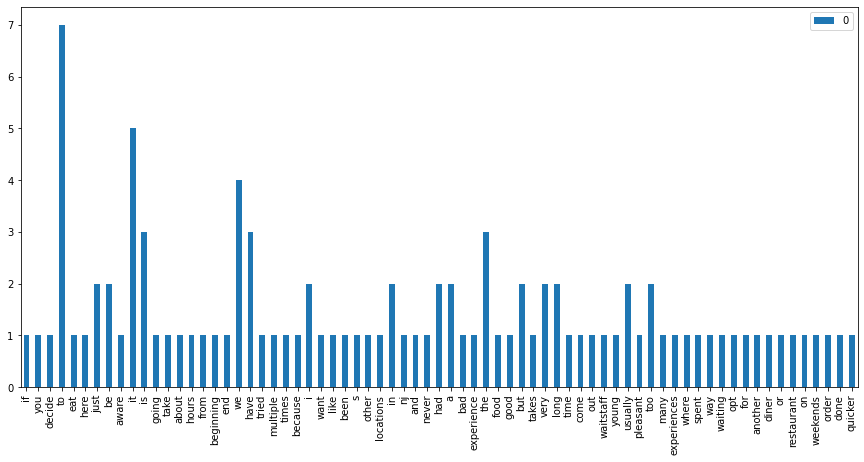

In [8]:
frequence_mot(premier_commentaire)

### Stop word

Nous devons maintenant supprimer tous les mots inutiles appelé "stopword" tel que les determinants etc.

In [9]:
# Les 100 mots les plus fréquents par défaut présent dans la 
# librairie NLTK
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /home/reda/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


On supprime ensuite les stopword présent dans notre commentaire à partir de la liste des stopword de la librairie ntlk. 

In [10]:
for stopword in stopwords.words('english'):
    for word in premier_commentaire:
        if stopword == word:
            premier_commentaire.remove(stopword)

print(premier_commentaire)

['decide', 'eat', 'aware', 'going', 'take', 'hours', 'beginning', 'end', 'tried', 'multiple', 'times', 'want', 'like', 'locations', 'nj', 'never', 'bad', 'experience', 'food', 'good', 'takes', 'long', 'time', 'come', 'waitstaff', 'young', 'usually', 'pleasant', 'many', 'experiences', 'spent', 'way', 'long', 'waiting', 'usually', 'opt', 'another', 'diner', 'restaurant', 'weekends', 'order', 'done', 'quicker']


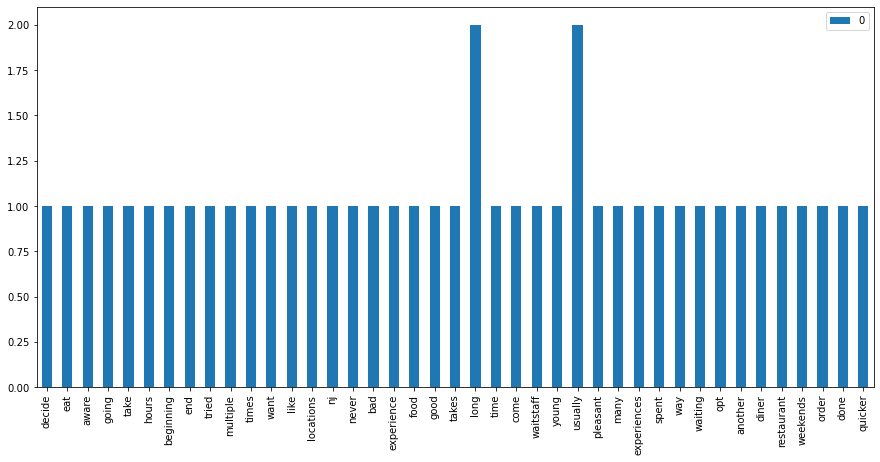

In [11]:
frequence_mot(premier_commentaire)

Nous devons aussi créer nos propres stopwrods. En effet, il suffit de récupérer les mots les plus présent dans notre texte, il est en effet peu probable que ces mots soient porteur de sens.

Pour le moment, nous faisons nos test sur un seul commentaire, il est donc normal d'avoir une distribution des mots très équitable.

In [12]:
dict_count_premier_commentaire = Counter(premier_commentaire)
dict_test = dict(
    reversed(
        sorted(dict_count_premier_commentaire.items(),
               key=lambda item: item[1])))

dict_test = {k: dict_test[k] for k in list(dict_test)[:100]}
liste_stopword = dict_test.keys()
liste_stopword

dict_keys(['usually', 'long', 'quicker', 'done', 'order', 'weekends', 'restaurant', 'diner', 'another', 'opt', 'waiting', 'way', 'spent', 'experiences', 'many', 'pleasant', 'young', 'waitstaff', 'come', 'time', 'takes', 'good', 'food', 'experience', 'bad', 'never', 'nj', 'locations', 'like', 'want', 'times', 'multiple', 'tried', 'end', 'beginning', 'hours', 'take', 'going', 'aware', 'eat', 'decide'])

Encore une fois, nous n'utilisons qu'un seul commentaire pour le moment, il est donc normal de ne pas avoir un résultat fiable.

Nos propres stopword ne seront pertinent que lorsque que nous procéderons avec beaucoup plus de commentaire.

TODO : AJOUTER UNE CELLULE POUR LA SUPPRESSION 100 MOTS LES PLUS UTILISES QUAND + DE TEXTES SERA UTILISE

### Lemmatisation

Le processus de **« lemmatisation »** consiste à représenter les mots sous leur forme **canonique**. 
Par exemple pour un **verbe, ce sera son infinitif**. Pour un nom, son masculin singulier. 

L'idée étant encore une fois de ne conserver que le sens des mots.

In [40]:
def lemmatisation(liste):
    lemmatizer = WordNetLemmatizer()

    premier_commentaire_lemm = []

    # Parcour la liste pour lemmatiser chaque mot
    for mot in liste:
        premier_commentaire_lemm.append(lemmatizer.lemmatize(mot))

    return premier_commentaire_lemm

In [41]:
lemmatisation(premier_commentaire)

['decide',
 'eat',
 'aware',
 'going',
 'take',
 'hour',
 'beginning',
 'end',
 'tried',
 'multiple',
 'time',
 'want',
 'like',
 'location',
 'nj',
 'never',
 'bad',
 'experience',
 'food',
 'good',
 'take',
 'long',
 'time',
 'come',
 'waitstaff',
 'young',
 'usually',
 'pleasant',
 'many',
 'experience',
 'spent',
 'way',
 'long',
 'waiting',
 'usually',
 'opt',
 'another',
 'diner',
 'restaurant',
 'weekend',
 'order',
 'done',
 'quicker']

In [46]:
# Compare les deux listes
print("Voici les mots qui ont été lemmatisés :\n")
print(list(set(premier_commentaire) - set(premier_commentaire_lemm)))

Voici les mots qui ont été lemmatisés :

['takes', 'times', 'locations', 'hours', 'weekends', 'experiences']


Nous avons donc lemmatiser notre liste de mot.

### Racinisation (stemming)

Cela consiste à ne conserver que la racine des mots étudiés. L'idée étant de supprimer les suffixes, préfixes et autres des mots afin de ne conserver que leur origine.

In [56]:
def racinisation(liste):
    stemmer = SnowballStemmer("english")

    premier_commentaire_racin = []

    # Parcour la liste pour lemmatiser chaque mot
    for mot in liste:
        premier_commentaire_racin.append(stemmer.stem(mot))

    return premier_commentaire_racin

In [57]:
racinisation(premier_commentaire_lemm)

['decid',
 'eat',
 'awar',
 'go',
 'take',
 'hour',
 'begin',
 'end',
 'tri',
 'multipl',
 'time',
 'want',
 'like',
 'locat',
 'nj',
 'never',
 'bad',
 'experi',
 'food',
 'good',
 'take',
 'long',
 'time',
 'come',
 'waitstaff',
 'young',
 'usual',
 'pleasant',
 'mani',
 'experi',
 'spent',
 'way',
 'long',
 'wait',
 'usual',
 'opt',
 'anoth',
 'diner',
 'restaur',
 'weekend',
 'order',
 'done',
 'quicker']

In [59]:
# Compare les deux listes
print("Voici les mots qui ont été lemmatisés :\n")
print(list(set(racinisation(premier_commentaire_lemm)) - set(premier_commentaire_lemm)))

Voici les mots qui ont été lemmatisés :

['restaur', 'locat', 'wait', 'go', 'usual', 'begin', 'experi', 'awar', 'multipl', 'anoth', 'decid', 'tri', 'mani']


En effet, la racinisation a supprimé les suffixes, préfixes, etc.

Par exemple le mot **"location" (localisation)** est devenu **"locat" (localiser)**, le mot **"experience" (experience)** est devenu **"experi" (experimenter)**.

Nous devons donc faire attention à ne pas changer le sens des mots.

TODO : ATTENTION AU SENS DES MOTS AVEC LA RACINISATION